In [1]:
import requests 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [2]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [3]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Let's index the data to embed it


In [5]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/usr/local/python/3.12.1/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [7]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

In [8]:
#Retrieval

def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [9]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [10]:
import os 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "YOUR SERVICE ACCOUNT"

In [12]:
!pip install google-cloud-aiplatform vertexai

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 56.4 MB/s eta 0:00:00
  Created wheel for google-crc32c: filename=google_crc32c-1.5.0-py3-none-any.whl size=13027 sha256=6e5ca5d0e86d22944a94f114e7fc943c23995ff6970d1b79f9604c64875f5fa7
  Stored in directory: /home/codespace/.cache/pip/wheels/40/b9/2e/089df51c5e6f7cda282c650457a1d9a7a55bf6386d8de8bf3d
Successfully built google-crc32c


In [11]:
from google.cloud import aiplatform
from vertexai.preview.generative_models import GenerativeModel, SafetySetting, HarmCategory, HarmBlockThreshold


def initialize_vertex_ai():
    aiplatform.init(project="YOUR PROJECT", location="REGION")

def flash(prompt):
    initialize_vertex_ai()
    model = GenerativeModel(
        model_name="gemini-1.5-flash-001"
    )
    generation_config = {
    "max_output_tokens": 8192,
    "temperature": 0.1,
    "top_p": 0.95,
    }
    safety_settings = {
        generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
         generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
         generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
         generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
    }
    responses = model.generate_content(
        prompt,
        generation_config=generation_config,
        safety_settings=safety_settings
    )

    

    response_obj = {
        "response_text": responses.text,
        "prompt_tokens": responses.usage_metadata.prompt_token_count,
        "result_tokens": responses.usage_metadata.candidates_token_count
    }
    
    return response_obj

def pro(prompt):
    initialize_vertex_ai()
    model = GenerativeModel(
        model_name="gemini-1.5-pro-001"
    )
    generation_config = {
    "max_output_tokens": 8192,
    "temperature": 0.1,
    "top_p": 0.95,
    }
    safety_settings = [
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
        threshold=SafetySetting.HarmBlockThreshold.BLOCK_ONLY_HIGH
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
        threshold=SafetySetting.HarmBlockThreshold.BLOCK_ONLY_HIGH
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
        threshold=SafetySetting.HarmBlockThreshold.BLOCK_ONLY_HIGH
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_HARASSMENT,
        threshold=SafetySetting.HarmBlockThreshold.BLOCK_ONLY_HIGH
    )]
    responses = model.generate_content(
        prompt,
        generation_config=generation_config,
        safety_settings=safety_settings
    )

    

    response_obj = {
        "response_text": responses.text,
        "prompt_tokens": responses.usage_metadata.prompt_token_count,
        "result_tokens": responses.usage_metadata.candidates_token_count
    }
    
    return response_obj



In [14]:
def rag_flash(query: dict) -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = flash(prompt)
    return answer

In [12]:
def rag_pro(query: dict) -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = pro(prompt)
    return answer

In [76]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [77]:
rag(ground_truth[10])

{'response_text': 'Yes, all sessions are recorded. You can watch them later if you miss one. \n',
 'prompt_tokens': 396,
 'result_tokens': 19}

In [82]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

In [13]:
answers = {}

In [14]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag_pro(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm['response_text'],
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
        'prompt_tokens': answer_llm['prompt_tokens'],
        'result_tokens': answer_llm['result_tokens']
    }

  0%|          | 0/1830 [00:00<?, ?it/s]

In [15]:
import pandas as pd

In [17]:
results_pro = [None] * len(ground_truth)

for i, val in answers.items():
    results_pro[i] = val.copy()
    results_pro[i].update(ground_truth[i])

In [87]:
results_flash = [None] * len(ground_truth)

for i, val in answers.items():
    results_flash[i] = val.copy()
    results_flash[i].update(ground_truth[i])

In [18]:
df_pro = pd.DataFrame(results_pro)

In [92]:
df_flash.sample(n=10)

,answer_llm,answer_orig,document,question,course,prompt_tokens,result_tokens
257,The Python libraries needed to generate a hist...,We can use histogram:\nimport pandas as pd\nim...,bbc0fca3,Which Python libraries are needed to generate ...,machine-learning-zoomcamp,671,63
1420,The provided context does not contain informat...,This deployment setup can be tested locally us...,0cfbe2e2,Are there any specific curl commands for testi...,machine-learning-zoomcamp,1071,110
570,Use the DictVectorizer. It preserves feature n...,These both methods receive the dictionary as a...,690d97f1,What should I use if I need to preserve featur...,machine-learning-zoomcamp,661,47
274,You needed to apply `fillna(0)` to all dataset...,I was using for loops to apply rmse to list of...,88e9600a,Why did you need to apply fillna(0) on all dat...,machine-learning-zoomcamp,705,90
1728,The FAQ database does not contain information ...,Problem happens when contacting the server wai...,cc60f7bc,What can I do if I encounter an error due to i...,machine-learning-zoomcamp,437,30
1360,To address issues caused by the arm architectu...,Problem:\nWhile trying to build docker image i...,35dbd6e2,How can I address issues caused by the arm arc...,machine-learning-zoomcamp,1689,50
825,"The command `docker image ls --format ""{{.Size...",Using the command docker images or docker imag...,514e27bb,Which command allows filtering the information...,machine-learning-zoomcamp,1176,39
1408,The FAQ database does not contain information ...,Add the next lines to vim /etc/docker/daemon.j...,1078aeb7,How can I resolve Docker name resolution issues?,machine-learning-zoomcamp,462,18
528,"In HW3 Q3, you should use the `ocean_proximity...",Question: Could you please help me with HW3 Q3...,fbda1f40,"In HW3 Q3, what should we use alongside the bi...",machine-learning-zoomcamp,591,32
1531,The migration instructions for AWS CLI v2 can ...,Make sure you are on AWS CLI v2 (check with aw...,00882c83,Where can I find migration instructions for AW...,machine-learning-zoomcamp,709,41


### Processing cost for the 1.8k requests of Gemini Flash 1.5

In [101]:
cost_per_1000_prompt_characters = 0.00001875
cost_per_1000_result_characters = 0.000075 
tokens_to_characters = 4

df_flash['prompt_caract'] = df_flash['prompt_tokens'] * tokens_to_characters
df_flash['result_caract'] = df_flash['result_tokens'] * tokens_to_characters

df_flash['prompt_cost'] = (df_flash['prompt_caract'] / 1000) * cost_per_1000_prompt_characters
df_flash['result_cost'] = (df_flash['result_caract'] / 1000) * cost_per_1000_result_characters

df_flash['total_cost'] = df_flash['prompt_cost'] + df_flash['result_cost']


total_cost = df_flash['total_cost'].sum()


print(f"The final cost for the process is: {total_cost} USD")


The final cost for the process is: 0.1318359 USD


### Processing cost for the 1.8k requests of Gemini Pro 1.5

In [47]:
cost_per_1000_prompt_characters = 0.00125 
cost_per_1000_result_characters = 0.00375  
tokens_to_characters = 4

df_pro['prompt_caract'] = df_pro['prompt_tokens'] * tokens_to_characters
df_pro['result_caract'] = df_pro['result_tokens'] * tokens_to_characters

df_pro['prompt_cost'] = (df_pro['prompt_caract'] / 1000) * cost_per_1000_prompt_characters
df_pro['result_cost'] = (df_pro['result_caract'] / 1000) * cost_per_1000_result_characters

df_pro['total_cost'] = df_pro['prompt_cost'] + df_pro['result_cost']


total_cost = df_pro['total_cost'].sum()


print(f"The final cost for the process for gemini pro is: {total_cost} USD")

The final cost for the process for gemini pro is: 8.492115 USD


In [19]:
df_pro.to_csv('data/results-pro.csv', index=False)

## Evaluate cosine similarity

In [104]:
results_flash = df_flash.to_dict(orient='records')

In [22]:
results_pro = df_pro.to_dict(orient="records")

In [23]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [41]:
similarity = []

for record in tqdm(results_flash):
    sim = compute_similarity(record)
    similarity.append(sim)

NameError: name 'results_flash' is not defined

In [39]:
similarity_2 = []

for record in tqdm(results_pro):
    sim = compute_similarity(record)
    similarity_2.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [40]:
df_pro['cosine'] = similarity_2
df_pro['cosine'].describe()

count    1830.000000
mean        0.623726
std         0.220312
min        -0.258050
25%         0.519167
50%         0.671628
75%         0.781661
max         0.993330
Name: cosine, dtype: float64

In [36]:
df_flash['cosine'] = similarity
df_flash['cosine'].describe()

count    1830.000000
mean        0.623726
std         0.220312
min        -0.258050
25%         0.519167
50%         0.671628
75%         0.781661
max         0.993330
Name: cosine, dtype: float64

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_31388/2462746627.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_flash['cosine'], label='gemini-flash-1.5')


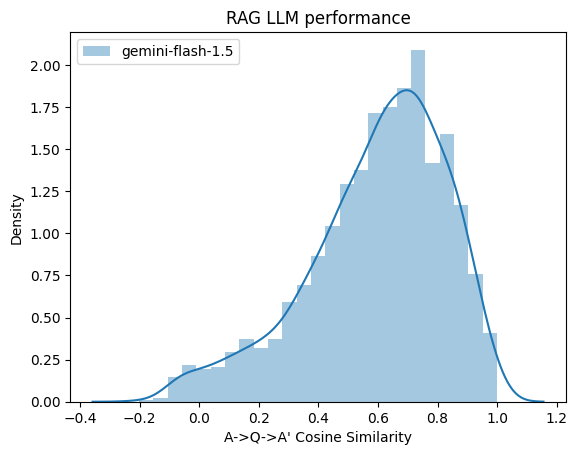

In [112]:
sns.distplot(df_flash['cosine'], label='gemini-flash-1.5')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()


In [34]:
df_gpt = pd.read_csv(r'/workspaces/llm-zoomcamp/module-4/data/results-gpt4o-mini-cosine.csv')
df_gpt.head()


,answer_llm,answer_orig,document,question,course,cosine
0,You can sign up for the course by going to the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp,0.416958
1,You can sign up for the course by visiting the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp,0.351351
2,"Yes, there is a FAQ for the Machine Learning c...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp,0.765016
3,The context does not provide a direct answer r...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp,0.006368
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp,0.339877


In [35]:
df_flash = pd.read_csv(r'/workspaces/llm-zoomcamp/module-4/data/results-flash.csv')
df_flash.head()

,answer_llm,answer_orig,document,question,course,prompt_tokens,result_tokens,prompt_caract,result_caract,prompt_cost,result_cost,total_cost
0,"I'm sorry, but the provided FAQ database does ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp,621,25,2484,100,0.000047,0.000007,0.000054
1,The sign-up link is: https://airtable.com/shry...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp,401,25,1604,100,0.000030,0.000007,0.000038
2,The provided context does not contain informat...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp,635,18,2540,72,0.000048,0.000005,0.000053
3,The FAQ database does not contain information ...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp,917,18,3668,72,0.000069,0.000005,0.000074
4,The FAQ database does not contain information ...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp,542,20,2168,80,0.000041,0.000006,0.000047


In [42]:
results_flash = df_flash.to_dict(orient='records')
similarity = []

for record in tqdm(results_flash):
    sim = compute_similarity(record)
    similarity.append(sim)
df_flash['cosine'] = similarity
df_flash['cosine'].describe()

  0%|          | 0/1830 [00:00<?, ?it/s]

count    1830.000000
mean        0.595950
std         0.233039
min        -0.202480
25%         0.465804
50%         0.631836
75%         0.765073
max         1.000000
Name: cosine, dtype: float64

In [45]:
df_35=pd.read_csv(r'/workspaces/llm-zoomcamp/module-4/data/results-gpt35-cosine.csv')
df_4o=pd.read_csv(r'/workspaces/llm-zoomcamp/module-4/data/results-gpt4o-cosine.csv')


/tmp/ipykernel_3200/3402974616.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt['cosine'], label='gpt-4o-mini')
/tmp/ipykernel_3200/3402974616.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_flash['cosine'], label='gemini-flash-1.5')
/tmp/ipykernel_3200/3402974616.py:3: UserWarn

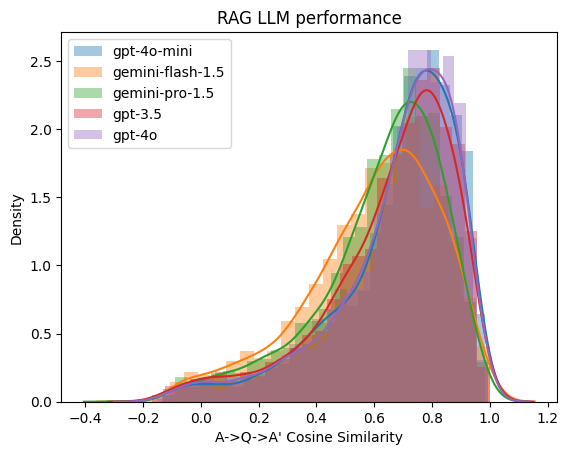

In [46]:
sns.distplot(df_gpt['cosine'], label='gpt-4o-mini')
sns.distplot(df_flash['cosine'], label='gemini-flash-1.5')
sns.distplot(df_pro['cosine'], label='gemini-pro-1.5')
sns.distplot(df_35['cosine'], label='gpt-3.5')
sns.distplot(df_4o['cosine'], label='gpt-4o')
plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()